# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import sklearn

X_PATH = '/Users/jiujiu/Desktop/caam-495-fluid-flow/Data'
# modify as needed for personal computer

# Exploratory Data Analysis

### Importing Data and resizing 

In [2]:
X_unsized = pd.read_csv(X_PATH + '/x.csv', header = None)
X_unsized.head()
X_unsized.shape
X_raw = np.resize(X_unsized.values, (120,300))

# Constructing Raw Dataset

In [ ]:
def create_dataset(X,window_len):
    """
    Takes in a timeseries X to create a dataset such that
    
    X_new = [[X_0,X_1,X_2,...,X_window_len],....[X_end-window_len,....,X_end]]
    Y_new = [X_window_len,....X_end]
    """
    X_new = []
    Y_new = X[window_len:]
    for index in range(len(X) - window_len):        
        temp = X[index]
        for i in range(1,window_len):
            temp = np.vstack((temp,X[index+i]))
        X_new.append(temp)
    X_new = np.stack(X_new)
    Y_new = np.stack(Y_new)
    return X_new,Y_new

### Sanity Check

In [4]:
X, Y = create_dataset(X_raw,3)
print('Shape of each x:',X[0].shape)
print('Size of X dataset:',X.shape)
print('Structure        : (sample, timesteps, x)')
print('Size of Y dataset:',Y.shape)

Shape of each x: (3, 300)
Size of X dataset: (117, 3, 300)
Structure        : (sample, timesteps, x)
Size of Y dataset: (117, 300)


# Plotting

(120, 300)


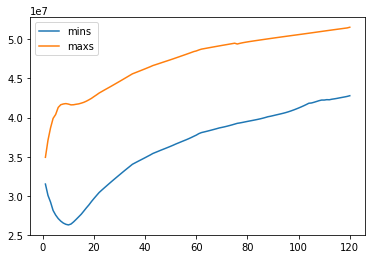

In [5]:
# Here we plot the maximum and minimum of all samples
print(np.shape(X_raw))
mins = np.zeros([len(X_raw),])
maxs = np.zeros([len(X_raw),])
for day in range(len(X_raw)):
    mins[day] = np.min(X_raw[day,])
    maxs[day] = np.max(X_raw[day,])

line1 = plt.plot(range(1,121),mins,label='mins')
line2 = plt.plot(range(1,121),maxs,label='maxs')
plt.legend()

# Normalizing Dataset

In [6]:
def scaledata(X,Y):
    n = len(X) # number of data entries
    stds = np.zeros([n,])
    means = np.zeros([n,])
    X_scaled = np.zeros(X.shape)
    Y_scaled = np.zeros(Y.shape)
    for i in range(n):
        stds[i] = np.std(X[i,0,:])
        means[i] = np.mean(X[i,0,:])
        X_scaled[i,] = np.true_divide(X[i,]-means[i],stds[i])
        Y_scaled[i,] = np.true_divide(Y[i,]-means[i],stds[i])
    return X_scaled,Y_scaled,stds,means
    
def rescaledata(stds,means,Y):
    if len(Y.shape) == 1:
        print('Y must be a 2D array with matching stds and means')
    else:
        # rescale data back, given particular Y
        n = Y.shape[0]
        rescaled_Y = np.zeros(Y.shape)
        for i in range(n):
            rescaled_Y[i] = stds[i]*Y[i,]+means[i]
    return rescaled_Y

In [7]:
def preparedata(X_raw,lookback,a,b,shuffle_flag):
    X, Y = create_dataset(X_raw,lookback)
    if lookback == 1:
        X = np.expand_dims(X, axis=1)
        Y = np.expand_dims(Y, axis=1)
    X_scaled,Y_scaled,stds,means = scaledata(X,Y)
    # Y_rescaled = rescaledata(stds,means,Y_scaled)
    random.seed(0)
    indices = list(range(len(X_scaled)))
    if shuffle_flag:
        print('Data shuffled')
        random.shuffle(indices)
    n = len(X)*a//(a+b)
    X_train = X_scaled[indices[:n],:,:]
    y_train = Y_scaled[indices[:n],:]
    X_test = X_scaled[indices[n:],:,:]
    y_test = Y_scaled[indices[n:],:] 
    stds = stds[indices]
    means = means[indices]
    stds_train = stds[:n]
    means_train = means[:n]
    stds_test = stds[n:]
    means_test = means[n:]
    return stds_train,means_train,X_train,y_train,stds_test,means_test,X_test,y_test

# Training Generic Neural Net

In [9]:
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM

def trainGeneric(lookback,X_raw,a,b,shuffle_flag):
    stds_train,means_train,X_train,y_train,stds_test,means_test,X_test,y_test = preparedata(X_raw,lookback,a,b,shuffle_flag)
    #y_train = np.expand_dims(y_train, axis=1)
    #y_test = np.expand_dims(y_test, axis=1)
    temp_train = X_train.reshape(X_train.shape[0],X_train.shape[1]*X_train.shape[2])
    temp_test = X_test.reshape(X_test.shape[0],X_test.shape[1]*X_test.shape[2])
    print(X_train.shape)
    print(temp_train.shape)

    # design network
    model = Sequential()
    #model.add(LSTM(4, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(100, input_shape=(temp_train.shape[1],)))
    model.add(Dense(300))

    #model.add(Dense(10))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # fit network
    history = model.fit(temp_train, y_train, batch_size = 10, epochs=100, validation_data=(temp_test, y_test), verbose=0, shuffle=True)
    # plot history
    plt.semilogy(np.array(history.history['loss'])/a, label='Training Error')
    plt.semilogy(np.array(history.history['val_loss'])/b, label='Test Error')
    plt.xlabel('Iteration')
    plt.ylabel('MSE')
    plt.legend()
    plt.show()
    model.summary()
    return model,stds_test,means_test,X_test,y_test


Using TensorFlow backend.


# LSTM RNN

In [31]:
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
def trainRNN(lookback,X_raw,a,b,shuffle_flag,LSTM_node):
    n = X_raw.shape[1] # size of input
    stds_train,means_train,X_train,y_train,stds_test,means_test,X_test,y_test = preparedata(X_raw,lookback,a,b,shuffle_flag)
    if lookback == 1:
        # change expected output shape if lookback is 1
        y_train = np.squeeze(y_train,axis = 1)
        y_test = np.squeeze(y_test,axis = 1)
    # build neural net
    model = Sequential()
    model.add(LSTM(LSTM_node, input_shape=(lookback, n)))
    model.add(Dense((n)))
    model.compile(loss='mean_squared_error', optimizer='adam')
    history = model.fit(X_train, y_train, epochs=100, batch_size=10, validation_data=(X_test, y_test), verbose=0, shuffle=False)
    # plot history
    plt.semilogy(np.array(history.history['loss'])/a/10, label='Training Error')
    plt.semilogy(np.array(history.history['val_loss'])/b, label='Test Error')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.show()
    model.summary()
    return model,stds_test,means_test,X_test,y_test


# Non-accumulative Test

Data shuffled
(93, 3, 300)
(93, 900)


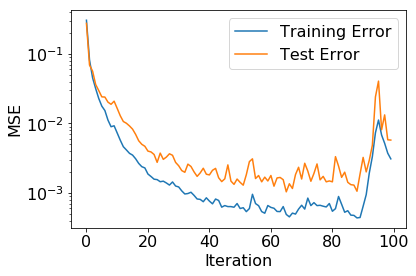

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 100)               90100     
_________________________________________________________________
dense_19 (Dense)             (None, 300)               30300     
Total params: 120,400
Trainable params: 120,400
Non-trainable params: 0
_________________________________________________________________
24/24 [==============================] - 0s 12ms/step
Randomly chosen index: 3


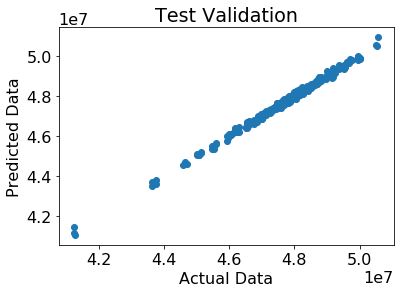

Slope =  0.9999101750979612
r squared =  0.9977950121299353


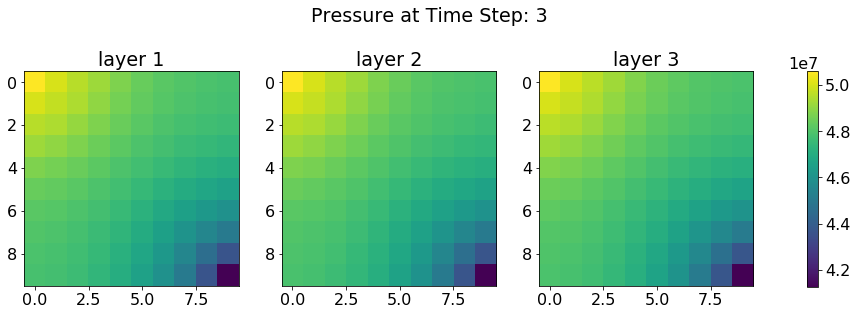

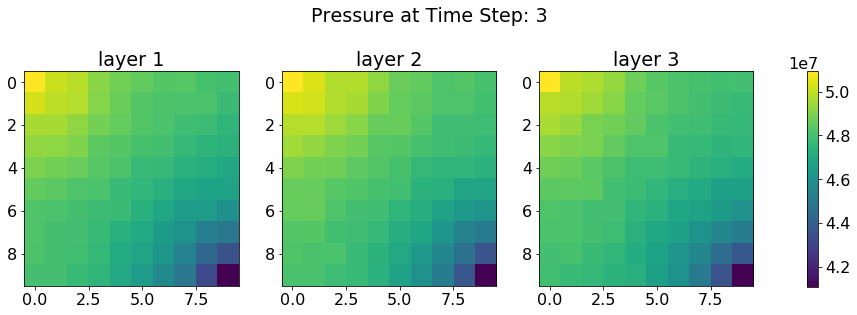

Data shuffled


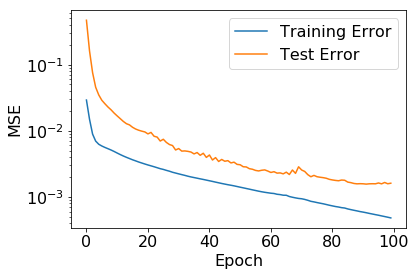

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 100)               160400    
_________________________________________________________________
dense_20 (Dense)             (None, 300)               30300     
Total params: 190,700
Trainable params: 190,700
Non-trainable params: 0
_________________________________________________________________
24/24 [==============================] - 1s 25ms/step
Randomly chosen index: 1


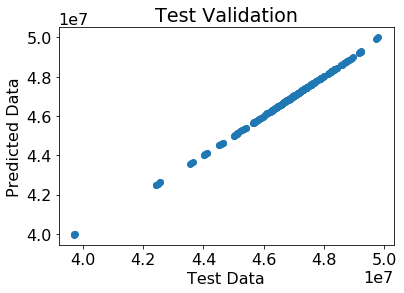

Slope =  0.9985926313422143
r squared =  0.9997252404224104


In [32]:
# import scipy
# a = 4
# b = 1
# lookback = 3
# shuffle_flag = 1
# LSTM_node = 100
# ######### test generic net #########
# model,stds_test,means_test,X_test,y_test = trainGeneric(lookback,X_raw,a,b,shuffle_flag)
# # visualize model prediction and validation
# y_predicted = model.predict(X_test,batch_size=None, verbose=1, steps=None)
# # rescale tested y
# y_test_rescaled = rescaledata(stds_test,means_test,y_test)
# y_predicted_rescaled = rescaledata(stds_test,means_test,y_predicted)
# # plot the comparison between original data and predicted data
# ind = np.random.randint(y_test.shape[0])
# print('Randomly chosen index:', ind)
# plt.plot(y_test_rescaled[ind,], y_predicted_rescaled[ind,],'o')
# plt.xlabel('Test Data')
# plt.ylabel('Predicted Data')
# plt.title('Test Validation')
# plt.show()
# slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_test_rescaled[ind,], y_predicted_rescaled[ind,])
# print('Slope = ',slope)
# print('r squared = ',r_value)


####### NEW ########
def plotresult(y,j,time):
    # plot vector jth column of y (300 x n)
    plt.rcParams.update({'font.size': 16})
    fig, axes = plt.subplots(1,3,figsize=(15,5))
    i = 0
    for ax in axes.flat:
        im = ax.imshow(y[j,].reshape((3,10,10))[i,:,:])
        titlestr = 'layer '+str(i+1)
        ax.set_title(titlestr)
        i += 1
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.2, 0.01, 0.6])
    fig.colorbar(im, cax=cbar_ax)
    fig.suptitle('Pressure at Time Step: ' + str(time))
#     fig.colorbar(im, ax=axes.ravel().tolist())
    plt.show()


import scipy
a = 4
b = 1
lookback = 3
shuffle_flag = 1
LSTM_node = 100
######### test generic net #########
model,stds_test,means_test,X_test,y_test = trainGeneric(lookback,X_raw,a,b,shuffle_flag)
# visualize model prediction and validation
y_predicted = model.predict(X_test.reshape((X_test.shape[0],X_test.shape[1]*X_test.shape[2])),batch_size=None, verbose=1, steps=None)
# rescale tested y
y_test_rescaled = rescaledata(stds_test,means_test,y_test)
y_predicted_rescaled = rescaledata(stds_test,means_test,y_predicted)
# plot the comparison between original data and predicted data
ind = np.random.randint(y_test.shape[0])
print('Randomly chosen index:', ind)
plt.rcParams.update({'font.size': 16})
plt.plot(y_test_rescaled[ind,], y_predicted_rescaled[ind,],'o')
plt.xlabel('Actual Data')
plt.ylabel('Predicted Data')
plt.title('Test Validation')
plt.show()
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_test_rescaled[ind,], y_predicted_rescaled[ind,])
print('Slope = ',slope)
print('r squared = ',r_value)

plotresult(y_test_rescaled,ind,ind)
plotresult(y_predicted_rescaled,ind,ind)
######### test RNN #########
model_1,stds_test,means_test,X_test,y_test = trainRNN(lookback,X_raw,a,b,shuffle_flag,LSTM_node)
y_predicted = model_1.predict(X_test,batch_size=None, verbose=1, steps=None)
# rescale tested y
y_test_rescaled = rescaledata(stds_test,means_test,y_test)
y_predicted_rescaled = rescaledata(stds_test,means_test,y_predicted)
# plot the comparison between original data and predicted data
# ind = np.random.randint(y_test.shape[0])
print('Randomly chosen index:', ind)
plt.plot(y_test_rescaled[ind,], y_predicted_rescaled[ind,],'o')
plt.xlabel('Test Data')
plt.ylabel('Predicted Data')
plt.title('Test Validation')
plt.show()
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_test_rescaled[ind,], y_predicted_rescaled[ind,])
print('Slope = ',slope)
print('r squared = ',r_value)

plotresult(y_test_rescaled,ind,ind)
plotresult(y_predicted_rescaled,ind,ind)
######### test CNN #########
# y_predicted = model_3.predict(X_test,batch_size=None, verbose=1, steps=None)




# Sequential Testing

In [135]:
from numpy import linalg as LA
def updateX(model,X_current,lookback):
    # take in the current X sample and update it using LSTM trained neural net
    # originally [X1 X2 .. X_lookback] -> [X2 .. X_lookback+1]
    X_c_train = np.expand_dims(X_current, axis=0)
    x_plusone = model.predict(X_c_train,batch_size=None, verbose=0, steps=None)
    if lookback == 1:
        X_next = x_plusone
    else:
        X_next = np.vstack((X_current[1:,],x_plusone))
    return X_next,x_plusone

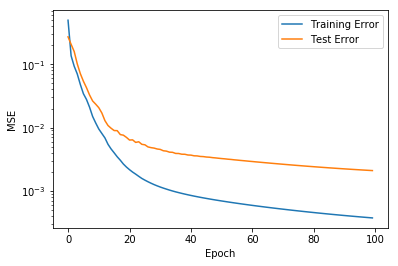

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_66 (Dense)             (None, 3, 300)            90300     
_________________________________________________________________
flatten_16 (Flatten)         (None, 900)               0         
_________________________________________________________________
dense_67 (Dense)             (None, 300)               270300    
Total params: 360,600
Trainable params: 360,600
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# RNN
lookback = 3
a = 4
b = 1
LSTM_node = 100
shuffle_flag = 0 # no shuffling if we want to stack predictions
model_1,stds_test,means_test,X_test,y_test = trainGeneric(lookback,X_raw,a,b,shuffle_flag)
model_2,stds_test2,means_test2,X_test2,y_test2 = trainRNN(lookback,X_raw,a,b,shuffle_flag,LSTM_node)

X_current1 = X_test[0,]
X_current2 = X_test[0,] # both X_test should be the same
m = y_test2.shape[0]
i = 0
errors1 = np.zeros(m)
errors2 = np.zeros(m)
while i < m:
    X_next1,y_predicted1 = updateX(model_1,X_current1,lookback)
    X_next2,y_predicted2 = updateX(model_2,X_current2,lookback)
    # rescale, optional
    y_test_rescaled = stds_test[i]*y_test[i,]+means_test[i]
    
    y_predicted_rescaled1 = stds_test[i]*y_predicted1+means_test[i]
    y_predicted_rescaled2 = stds_test[i]*y_predicted2+means_test[i]
    
    X_current1 = X_next1
    X_current2 = X_next2
    errors1[i] = LA.norm(y_test_rescaled-y_predicted_rescaled1)/LA.norm(y_test_rescaled)
    errors2[i] = LA.norm(y_test_rescaled-y_predicted_rescaled2)/LA.norm(y_test_rescaled)
    i += 1
plt.semilogy(errors1,'-*',label = 'Generic')
plt.semilogy(errors2,'-*',label = 'RNN')
plt.xlabel('Time Step')
plt.ylabel('Error')
plt.title('Sequential Prediction Comparison')
plt.legend()
plt.show()